In [1]:
RANDOM_STATE = 42

In [2]:
from duplebalance import DupleBalanceClassifier
from duplebalance.base import sort_dict_by_key

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [3]:
X, y = make_classification(n_classes=5, class_sep=1, # 5-class
    weights=[0.05, 0.05, 0.15, 0.25, 0.5], n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1, n_samples=2000, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

origin_distr = sort_dict_by_key(Counter(y_train))
test_distr = sort_dict_by_key(Counter(y_test))
print('Original training dataset shape %s' % origin_distr)
print('Original test dataset shape %s' % test_distr)

Original training dataset shape {0: 52, 1: 48, 2: 145, 3: 268, 4: 487}
Original test dataset shape {0: 48, 1: 52, 2: 155, 3: 232, 4: 513}


In [4]:
from imbalanced_ensemble.ensemble import *

n_estimators_list = [1, 3, 5, 10, 20]

ensemble_init_kwargs = {
    'base_estimator': DecisionTreeClassifier(),
    'random_state': RANDOM_STATE,
}
dube_fit_kwargs = {
    'resampling_target': 'under',
    'resampling_strategy': 'shem',
    'perturb_alpha': .5,
}

eval_kwargs = {'average': 'macro', 'multi_class': 'ovo'}

ensemble_clfs = {
    'DuBE': DupleBalanceClassifier,
    'RusBoost': RUSBoostClassifier,
    'OverBoost': OverBoostClassifier,
    'SmoteBoost': SMOTEBoostClassifier,
    'RusBoost': RUSBoostClassifier,
    'UnderBagging': UnderBaggingClassifier,
    'OverBagging': OverBaggingClassifier,
    'SmoteBagging': SMOTEBaggingClassifier,
    'Cascade': BalanceCascadeClassifier,
    'SelfPacedEns': SelfPacedEnsembleClassifier,
}

# Initialize results list
all_results = []

for ens_name, clf_class in ensemble_clfs.items():
    for n_estimators in n_estimators_list:
        # Train all ensemble classifiers
        clf = clf_class(
            n_estimators = n_estimators,
            **ensemble_init_kwargs
        )
        if ens_name == 'DuBE':
            clf.fit(X_train, y_train, **dube_fit_kwargs)
        else: clf.fit(X_train, y_train)
        y_pred_proba = clf.predict_proba(X_test)
        score = roc_auc_score(y_test, y_pred_proba, **eval_kwargs)
        print ("{:<15s} {:<2d} | Balanced AUROC: {:.3f} | #Training Samples: {:d}".format(
            ens_name, n_estimators, score, sum(clf.estimators_n_training_samples_)
            ))
        all_results.append(
            [ens_name, score, n_estimators, sum(clf.estimators_n_training_samples_)]
        )

DuBE            1  | Balanced AUROC: 0.869 | #Training Samples: 240
DuBE            3  | Balanced AUROC: 0.945 | #Training Samples: 720
DuBE            5  | Balanced AUROC: 0.965 | #Training Samples: 1200
DuBE            10 | Balanced AUROC: 0.977 | #Training Samples: 2400
DuBE            20 | Balanced AUROC: 0.984 | #Training Samples: 4800
RusBoost        1  | Balanced AUROC: 0.860 | #Training Samples: 240
RusBoost        3  | Balanced AUROC: 0.898 | #Training Samples: 720
RusBoost        5  | Balanced AUROC: 0.902 | #Training Samples: 1200
RusBoost        10 | Balanced AUROC: 0.889 | #Training Samples: 2400
RusBoost        20 | Balanced AUROC: 0.905 | #Training Samples: 4800
OverBoost       1  | Balanced AUROC: 0.852 | #Training Samples: 2435
OverBoost       3  | Balanced AUROC: 0.868 | #Training Samples: 7305
OverBoost       5  | Balanced AUROC: 0.881 | #Training Samples: 12175
OverBoost       10 | Balanced AUROC: 0.884 | #Training Samples: 24350
OverBoost       20 | Balanced AUROC:

<AxesSubplot:title={'center':'DuBE versus Ensemble Baselines'}, xlabel='#Training Samples', ylabel='AUROC (macro)'>

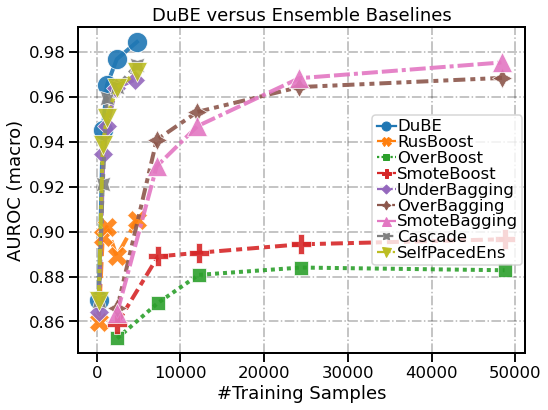

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

all_results_columns = ['Method', 'AUROC (macro)', '#Base Learners', '#Training Samples']
data_vis = pd.DataFrame(all_results, columns=all_results_columns)


def plot_results_comp(data_vis, x, y, title, figsize=(8,6)):
    fig = plt.figure(figsize=figsize)
    ax = sns.lineplot(
        data=data_vis, x=x, y=y, hue='Method', style='Method',
        markers=True, err_style='bars', linewidth=4, markersize=20, alpha=0.9
    )
    for position, spine in ax.spines.items():
        spine.set_color('black')
        spine.set_linewidth(2)
    ax.grid(color = 'black', linestyle='-.', alpha=0.3)
    ax.set_ylabel('AUROC (macro)')
    ax.set_title(title)
    ax.legend(
        title='',
        borderpad=0.25,
        columnspacing=0.05,
        borderaxespad=0.15,
        handletextpad=0.05,
        labelspacing=0.05,
        handlelength=1.2,
        )
    return ax

plot_results_comp(data_vis, x='#Training Samples', y='AUROC (macro)',
                  title='DuBE versus Ensemble Baselines')

<AxesSubplot:title={'center':'DuBE versus Ensemble Baselines'}, xlabel='#Base Learners', ylabel='AUROC (macro)'>

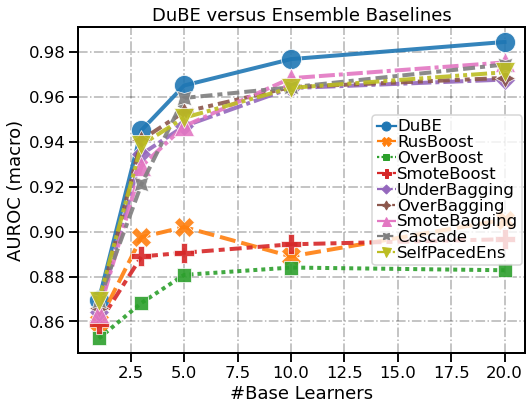

In [6]:
plot_results_comp(data_vis, x='#Base Learners', y='AUROC (macro)',
                  title='DuBE versus Ensemble Baselines')